In [ ]:
# ####### Install necessary libraries ####### #
!pip install pandas

In [ ]:
# ####### Import libraries ####### #
import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from googleapiclient.discovery import build
import os

The dataframe called bb is for bad bills. It is a table of state bills that are being worked on this year in the state legislature. It has one line for each bill with things like the description of the bill, who the bill sponsor is, some tags for whether the bill reads as positive, neutral or negative in terms of being for the people. things like that

In [ ]:
# I have a spreadsheet where i've compiled data from @elevate_pac TikTok account
# The spreadsheet has info about some bills in the utah legislature and their status
# I want to use this info to create timelines showing where the bills are in the process
# ####### Mount Google Drive to Colab ####### #
from google.colab import drive
drive.mount('/content/drive')

# ####### Authenticate
auth.authenticate_user()

from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)
drive_service = build('drive', 'v3', credentials=creds)

# function to loop through google drive folder and make a list of file id's
def get_sheet_urls_from_folder(folder_id):
    query = f"'{folder_id}' in parents and mimeType='application/vnd.google-apps.spreadsheet'"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    files = results.get('files', [])
    print(f"Found {len(files)} files in the folder:")
    [print(file['name']) for file in files]
    return [f"https://docs.google.com/spreadsheets/d/{file['id']}" for file in files]

def read_google_sheet(sheet_url, worksheet_name=None):
    # Open the Google Sheet by its URL
    sheet = gc.open_by_url(sheet_url)
    # Select the worksheet
    if worksheet_name:
        worksheet = sheet.worksheet(worksheet_name)
    else:
        worksheet = sheet.get_worksheet(0)  # Default to the first sheet

    # Convert the worksheet to a DataFrame
    df = get_as_dataframe(worksheet, evaluate_formulas=True).dropna(how='all')  # Drop rows that are completely empty
    df['sheet_name'] = sheet.title  # Add a column with the sheet name
    return df

# There's a weird warning about the format and openpyxl but we don't gotta worry about that so ignore it
import warnings
warnings.simplefilter("ignore")

# Get the URLs of each Google Sheet
sheet_url = get_sheet_urls_from_folder('1nkEW1IeBOSuSaDkQ4IA27DO23_6AXlU8')

all_data = []

for url in sheet_url:
    try:
        df = read_google_sheet(url)
        all_data.append(df)
    except Exception as e:
        print(f"Could not read {url}: {e}")

bb = pd.concat(all_data, ignore_index=True)

# Check data
# print(bb.head())
print(bb.info())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1 files in the folder:
utah_bad_bills_overview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Record ID     123 non-null    float64
 1   Bill Number   123 non-null    object 
 2   Bill Title    123 non-null    object 
 3   Description   121 non-null    object 
 4   Notecard      122 non-null    object 
 5   Topics        123 non-null    object 
 6   Read          123 non-null    object 
 7   Category      68 non-null     object 
 8   Sub Category  2 non-null      object 
 9   Bill Sponsor  123 non-null    object 
 10  sheet_name    123 non-null    object 
dtypes: float64(1), object(10)
memory usage: 10.7+ KB
None


In [ ]:
# Clean up data

bb['Record ID'] = bb['Record ID'].astype(int)  # Convert Record ID to integer

# Remove duplicates
def prioritize_rows(group):
    # If at least one row has both Notecard and Description, prioritize keeping it
    rows_with_both = group.dropna(subset=['Notecard', 'Description'])
    if not rows_with_both.empty:
        return rows_with_both.iloc[:1]  # Keep only one row

    # If at least one row has a Notecard, keep it
    rows_with_notecard = group.dropna(subset=['Notecard'])
    if not rows_with_notecard.empty:
        return rows_with_notecard.iloc[:1]

    # If at least one row has a Description, keep it
    rows_with_description = group.dropna(subset=['Description'])
    if not rows_with_description.empty:
        return rows_with_description.iloc[:1]

    # If all rows are completely empty (very rare), keep the first occurrence
    return group.iloc[:1]


# Group by 'Bill Number' and 'Bill Title' and apply prioritization
bb = bb.groupby("Bill Number", group_keys=False).apply(prioritize_rows).reset_index(drop=True)

# Reset index
bb.reset_index(drop=True, inplace=True)

# Fill missing values where appropriate
bb['Description'].fillna('No description available', inplace=True)
bb['Topics'].fillna('Other', inplace=True)
bb['Read'].fillna('Not specified', inplace=True)

# Ensure all text columns are strings
text_columns = ['Bill Number', 'Bill Title', 'Description', 'Notecard', 'Topics', 'Read', 'Bill Sponsor', 'sheet_name']
bb[text_columns] = bb[text_columns].astype(str)

# Trim whitespace from all string columns
bb = bb.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Replace empty strings with NaN for consistency
bb.replace("", pd.NA, inplace=True)

# Create a column called 'Office' and use 'Bill Sponsor' to populate the value
bb['Office'] = bb['Bill Sponsor'].apply(lambda x: 'State House' if str(x).startswith('Rep.') else
                                                  'State Senate' if str(x).startswith('Sen.') else pd.NA)
# Remove the prefix from the 'Bill Sponsor'
bb['Bill Sponsor'] = bb['Bill Sponsor'].apply(lambda x: x.replace('Rep.', '').replace('Sen.', '').strip())

# Display results
print(bb[['Bill Sponsor', 'Office']].head())

# Display cleaned dataframe info
print(bb.info())
# print(bb.head())


            Bill Sponsor       Office
0           Tyler Clancy  State House
1          Angela Romero  State House
2  Kay J. Christofferson  State House
3          Joseph Elison  State House
4        Andrew Stoddard  State House
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Record ID     122 non-null    int64 
 1   Bill Number   122 non-null    object
 2   Bill Title    122 non-null    object
 3   Description   122 non-null    object
 4   Notecard      122 non-null    object
 5   Topics        122 non-null    object
 6   Read          122 non-null    object
 7   Category      68 non-null     object
 8   Sub Category  2 non-null      object
 9   Bill Sponsor  122 non-null    object
 10  sheet_name    122 non-null    object
 11  Office        121 non-null    object
dtypes: int64(1), object(11)
memory usage: 11.6+ KB
None


In [ ]:
bb['Office'].value_counts()

,count
Office,
State House,87
State Senate,34


In [ ]:
bb.loc[bb['Record ID'] == 99]

,Record ID,Bill Number,Bill Title,Description,Notecard,Topics,Read,Category,Sub Category,Bill Sponsor,sheet_name,Office
10,99,HB 169,State Board of Education Amendments,No description available,School Board Ethics and Accountibility,Education,Negative,NaN,NaN,Douglas R. Welton,utah_bad_bills_overview,State House


In [ ]:
bb.loc[bb['Bill Number']=='TEST RECORD']

,Record ID,Bill Number,Bill Title,Description,Notecard,Topics,Read,Category,Sub Category,Bill Sponsor,sheet_name,Office
121,101,TEST RECORD,TEST RECORD,TEST RECORD,TEST RECORD,TEST RECORD,TEST RECORD,NaN,NaN,TEST RECORD,utah_bad_bills_overview,<NA>


In [ ]:
# DROP TEST RECORD, JUST THERE TO CHECK FOR DUPLICATES AND SUCH
bb = bb[bb['Bill Number'] != 'TEST RECORD'].copy().reset_index(drop=True)

This new dataframe called updts is from a google sheet that has the bill number and the 'Notecard' from the bb data but then it has columns for the status of the bill (Process Tag), the date the status changed (Date) and what day of the legislature that it is (Day of Legislature). I want to use this date to create a timeline of the bills.

In [ ]:
# import bad bills daily update file for the daily updates to the bills
sheet_url = get_sheet_urls_from_folder('1vD6e4XnGPSQsy0qm79TKIeRsUe0luewR')

updates = read_google_sheet(sheet_url[0])

# Check data
# print(updates.head())
print(updates.info())

Found 1 files in the folder:
bad_bills_daily_update
<class 'pandas.core.frame.DataFrame'>
Index: 432 entries, 0 to 431
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Record_ID           432 non-null    float64
 1   Bill Number         432 non-null    object 
 2   Notecard            432 non-null    object 
 3   Process Tag         432 non-null    object 
 4   Date                432 non-null    object 
 5   Day of Legislature  432 non-null    float64
 6   Progress            432 non-null    float64
 7   sheet_name          432 non-null    object 
dtypes: float64(3), object(5)
memory usage: 30.4+ KB
None


In [ ]:
# Clean up the data

# Convert Record ID to int
updates['Record_ID'] = updates['Record_ID'].astype(int)

# Remove extra whitespace in text fields
updates['Bill Number'] = updates['Bill Number'].str.strip()
updates['Notecard'] = updates['Notecard'].str.strip()
updates['Process Tag'] = updates['Process Tag'].str.strip()

# Convert Date to datetime format
updates['Date'] = pd.to_datetime(updates['Date'], errors='coerce')

# Convert Day of Legislature to int, handling NaN values
updates['Day of Legislature'] = pd.to_numeric(updates['Day of Legislature'], errors='coerce').fillna(0).astype(int)

# Drop duplicates if necessary
updates.drop_duplicates(subset=['Bill Number', 'Notecard', 'Process Tag', 'Date'], inplace=True)

# Fill missing values if needed (adjust based on context)
updates.fillna({'Process Tag': 'Unknown', 'Day of Legislature': 0}, inplace=True)

# Print summary to verify changes
print(updates.info())
# print(updates.head())


<class 'pandas.core.frame.DataFrame'>
Index: 429 entries, 0 to 431
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Record_ID           429 non-null    int64         
 1   Bill Number         429 non-null    object        
 2   Notecard            429 non-null    object        
 3   Process Tag         429 non-null    object        
 4   Date                429 non-null    datetime64[ns]
 5   Day of Legislature  429 non-null    int64         
 6   Progress            429 non-null    float64       
 7   sheet_name          429 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 30.2+ KB
None


In [ ]:
# Let's save the cleaned data for the bb and updates dataframes
# save a copy of the data to a csv
filepath = '/content/drive/My Drive/ElectionTime/data/'
filename2 = "bad_bills_updates.csv"
filenema3 = "bad_bills.csv"

updates.to_csv(filepath + filename2, index=False)
bb.to_csv(filepath + filenema3, index=False)

In [ ]:
''' Now for the process tags there is a specified order. A typical bill will follow this order
It starts in the house that submitted it so if it's a house bill (prefix HB) it starts in the house
and if it's a senate bill (prefix SB) it starts in the senate.
The bill will go through rules, committee and than 3 votes on the floor then repeat those same steps
for the other house or senate. The bill then goes to the governor to sign and then the bill will have
officially passed. If when the bill is in the second house and they make changes to the bill it will go back
to the original house for concurrance before going to the governor. Any bill can go to the graveyard at any
point in the process. This doesn't alway mean it was voted down but could just be held in committee
or something. but based off how they tipically operate it will likely be discarded and never go any further
but a bill can come back from the graveyard and continue in the process from where it left off.
'''

" Now for the process tags there is a specified order. A typical bill will follow this order \nIt starts in the house that submitted it so if it's a house bill (prefix HB) it starts in the house\nand if it's a senate bill (prefix SB) it starts in the senate.\nThe bill will go through rules, committee and than 3 votes on the floor then repeat those same steps \nfor the other house or senate. The bill then goes to the governor to sign and then the bill will have \nofficially passed. If when the bill is in the second house and they make changes to the bill it will go back\nto the original house for concurrance before going to the governor. Any bill can go to the graveyard at any\npoint in the process. This doesn't alway mean it was voted down but could just be held in committee \nor something. but based off how they tipically operate it will likely be discarded and never go any further\nbut a bill can come back from the graveyard and continue in the process from where it left off. \n"

In [ ]:
# from pandas.api.types import CategoricalDtype

# # This ensures the process tags maintain a defined order so when building the
# # timeline it always follows this order even if some steps are skipped
# process_order = [
#     "Rules 1", "Committee 1", "Floor Vote 1.1", "Floor Vote 1.2", "Floor Vote 1.3",
#     "Rules 2", "Committee 2", "Floor Vote 2.1", "Floor Vote 2.2", "Floor Vote 2.3",
#     "Concurrence", "Governor", "Bill Passed",  "Graveyard", "Vetoed"
# ]

# process_cat = CategoricalDtype(categories=process_order, ordered=True)
# updates['Process Tag'] = updates['Process Tag'].astype(process_cat)

# # The graveyard tag is a special situation because bills can move in an out
# # so we need a way to track the sequence of changes for each bill

# updates = updates.sort_values(by=['Bill Number', 'Date', 'Process Tag'])


In [ ]:
updates.loc[updates['Bill Number'] == 'HB 209']

,Record_ID,Bill Number,Notecard,Process Tag,Date,Day of Legislature,Progress,sheet_name
93,94,HB 209,"Trust Us, We're Parents",Floor Vote 1.1,2025-02-03,14,3.0,bad_bills_daily_update
94,95,HB 209,"Trust Us, We're Parents",Rules 2,2025-02-06,17,6.0,bad_bills_daily_update
95,96,HB 209,"Trust Us, We're Parents",Committee 2,2025-02-18,29,7.0,bad_bills_daily_update
96,97,HB 209,"Trust Us, We're Parents",Floor Vote 2.1,2025-02-19,30,8.0,bad_bills_daily_update
97,98,HB 209,"Trust Us, We're Parents",Floor Vote 2.2,2025-02-20,31,9.0,bad_bills_daily_update
350,351,HB 209,"Trust Us, We're Parents",Floor Vote 2.3,2025-02-27,38,10.0,bad_bills_daily_update
405,406,HB 209,"Trust Us, We're Parents",Concurrance,2025-03-03,42,10.5,bad_bills_daily_update


In [ ]:
# There are also columns in the updates and bb dataframes that we won't need for our merged data ta
# ignore errors in case the column isn't in the dataframe

bb = bb.drop(columns=["Record ID", "sheet_name", "Category", "Sub Category"], errors="ignore")
updates = updates.drop(columns=["Record_ID", "sheet_name", 'Notecard'], errors="ignore")


In [ ]:
# Now we can merge the bb and the updates dataframes
# I'll use the Bill Number field for the merge because this should be an exact match in both dfs

merged_df = updates.merge(bb, on="Bill Number", how="left", suffixes=("_updates", "_bb"))

# check for missing bills
missing_bills = merged_df[merged_df['Bill Title'].isna()]
print("Bills in updates but not in bb:\n", missing_bills[['Bill Number']])

Bills in updates but not in bb:
 Empty DataFrame
Columns: [Bill Number]
Index: []


In [ ]:
# Let's make sure the merged dataframe is sorted correctly for the timeline
merged_df = merged_df.sort_values(by=['Bill Number', 'Date', 'Process Tag'])
# Reset the index to make sure it's all clean
merged_df.reset_index(drop=True, inplace=True)
# save a copy of the data to a csv
filename1 = "merged_bad_bills.csv"
merged_df.to_csv(filepath + filename1, index=False)  # Save for review

merged_df

,Bill Number,Process Tag,Date,Day of Legislature,Progress,Bill Title,Description,Notecard,Topics,Read,Bill Sponsor,Office
0,HB 100,Committee 2,2025-02-27,38,7.0,Food Security Amendments,Will fund free school lunch for students that ...,Food Security for Students,"Education, Children's Health",Positive,Tyler Clancy,State House
1,HB 100,Rules 2,2025-02-27,38,6.0,Food Security Amendments,Will fund free school lunch for students that ...,Food Security for Students,"Education, Children's Health",Positive,Tyler Clancy,State House
2,HB 100,Floor Vote 2.1,2025-03-03,42,8.0,Food Security Amendments,Will fund free school lunch for students that ...,Food Security for Students,"Education, Children's Health",Positive,Tyler Clancy,State House
3,HB 101,Rules 1,2025-01-21,1,1.0,Ballot Proposition Amendments,Requires an impartial source to write the lang...,Ballot Initiative Transparency & Accuracy,Election,Positive,Angela Romero,State House
4,HB 106,Floor Vote 1.1,2025-02-25,36,3.0,Income Tax Revisions,Income tax cut bill gives the average Utahn ar...,$45 a year? Hell yeah!,Taxes,Negative,Kay J. Christofferson,State House
...,...,...,...,...,...,...,...,...,...,...,...,...
424,SJR 9,Floor Vote 1.1,2025-02-19,30,3.0,Joint Resolution Amending Rules of Civil Proce...,If the legislature passes a bill that is uncon...,"You Snooze, You Lose (Your Rights)","Government, Judicial",Negative,Brady Brammer,State Senate
425,SJR 9,Floor Vote 1.2,2025-02-20,31,4.0,Joint Resolution Amending Rules of Civil Proce...,If the legislature passes a bill that is uncon...,"You Snooze, You Lose (Your Rights)","Government, Judicial",Negative,Brady Brammer,State Senate
426,SJR 9,Rules 2,2025-02-28,39,6.0,Joint Resolution Amending Rules of Civil Proce...,If the legislature passes a bill that is uncon...,"You Snooze, You Lose (Your Rights)","Government, Judicial",Negative,Brady Brammer,State Senate
427,SJR 9,Committee 2,2025-03-03,42,7.0,Joint Resolution Amending Rules of Civil Proce...,If the legislature passes a bill that is uncon...,"You Snooze, You Lose (Your Rights)","Government, Judicial",Negative,Brady Brammer,State Senate


In [ ]:
# look at count of bills by date sorted by most to least
merged_df.groupby('Date')['Bill Sponsor'].count().sort_values(ascending=False)

,Bill Sponsor
Date,
2025-03-03,43
2025-02-27,43
2025-02-21,37
2025-02-28,31
2025-02-20,22
2025-02-18,22
2025-02-03,20
2025-03-04,18
2025-02-25,18


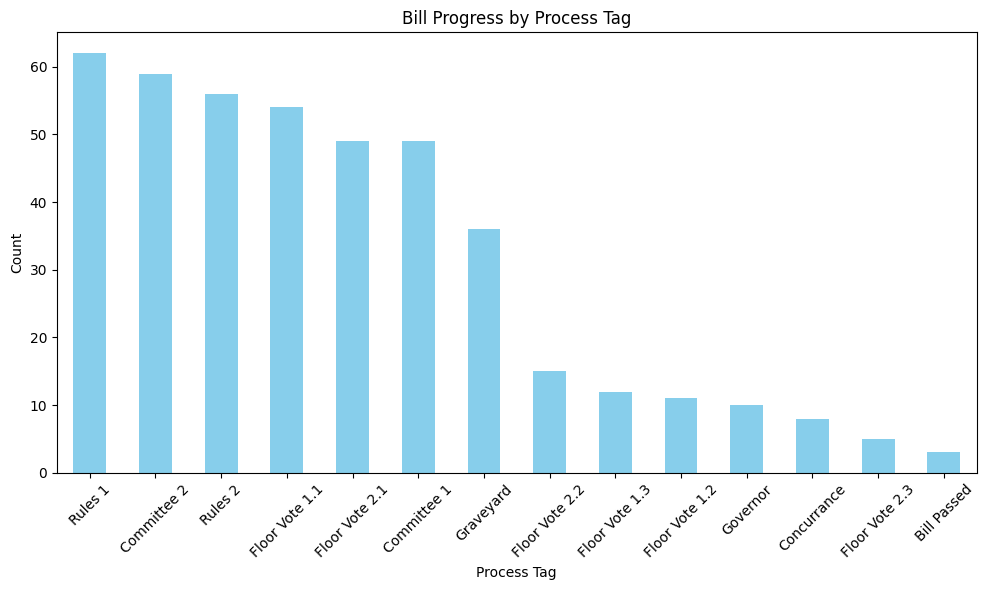

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each process tag
process_tag_counts = merged_df['Process Tag'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10,6))
process_tag_counts.plot(kind='bar', color='skyblue')
plt.title('Bill Progress by Process Tag')
plt.xlabel('Process Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


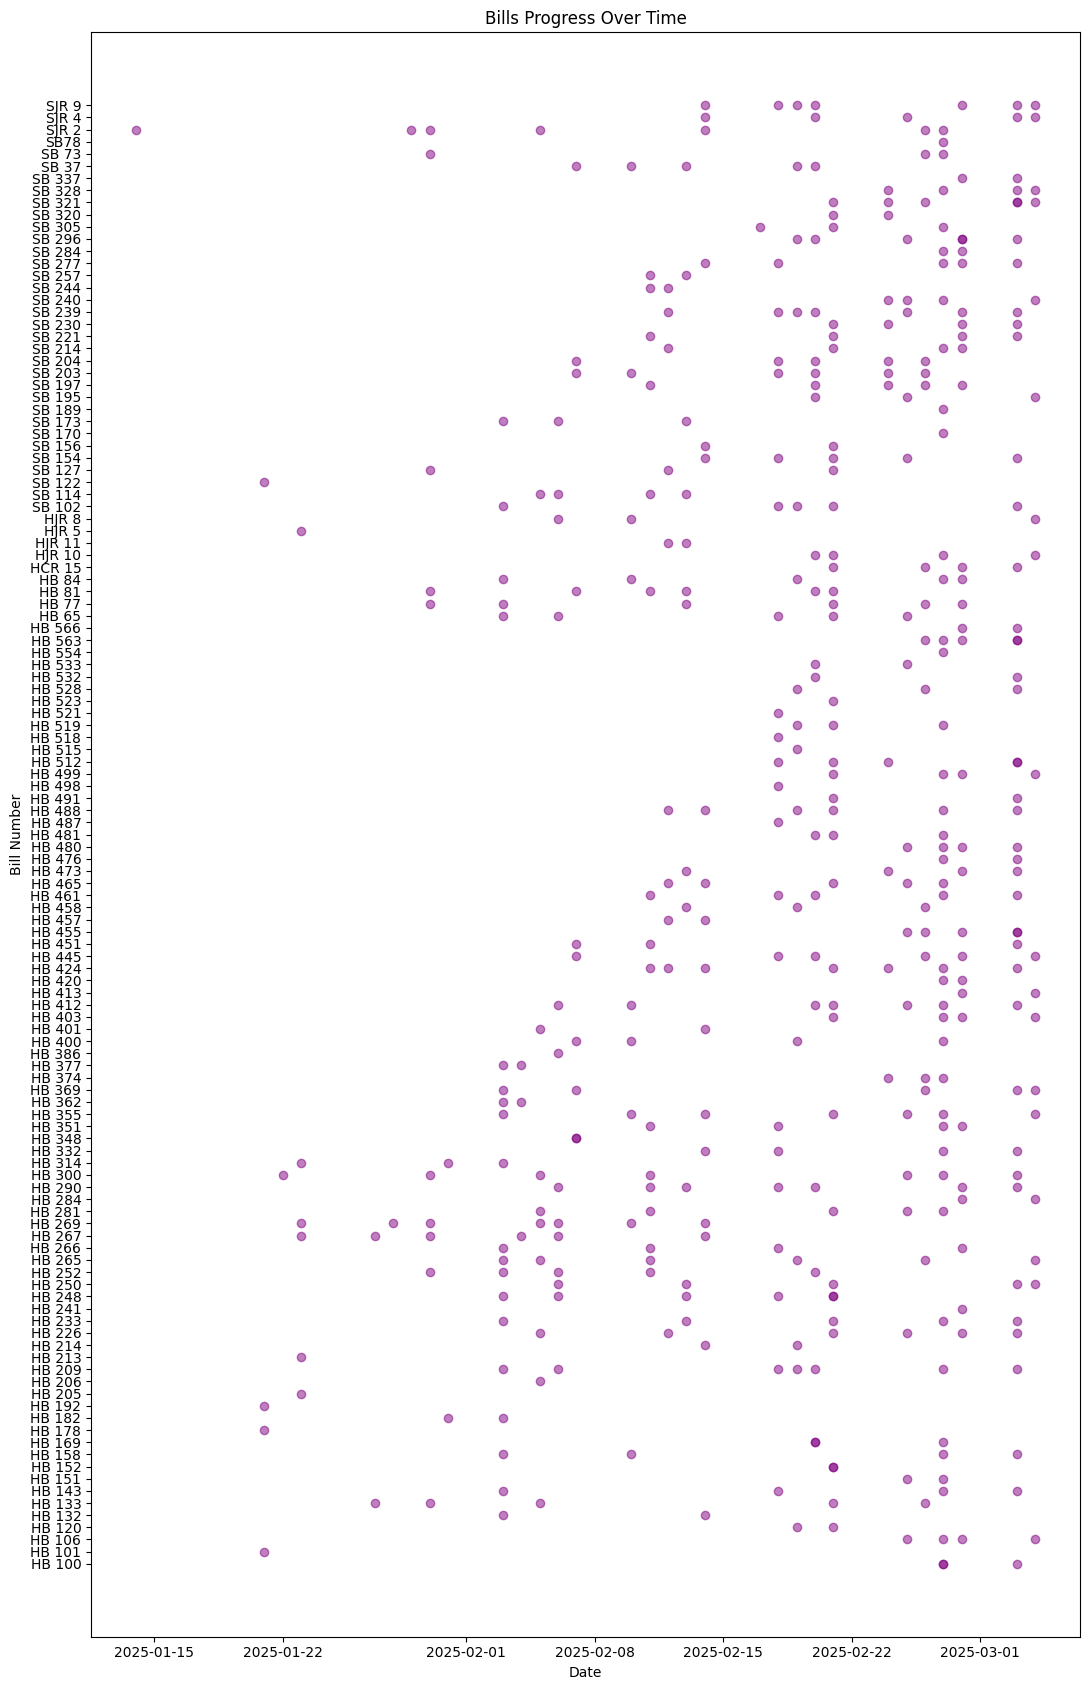

In [ ]:
# Plotting the timeline of bills (using Date for simplicity)
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')  # Handle invalid dates

plt.figure(figsize=(11,17))
plt.scatter(merged_df['Date'], merged_df['Bill Number'], alpha=0.5, color='purple')
plt.title('Bills Progress Over Time')
plt.xlabel('Date')
plt.ylabel('Bill Number')
plt.tight_layout()
plt.show()


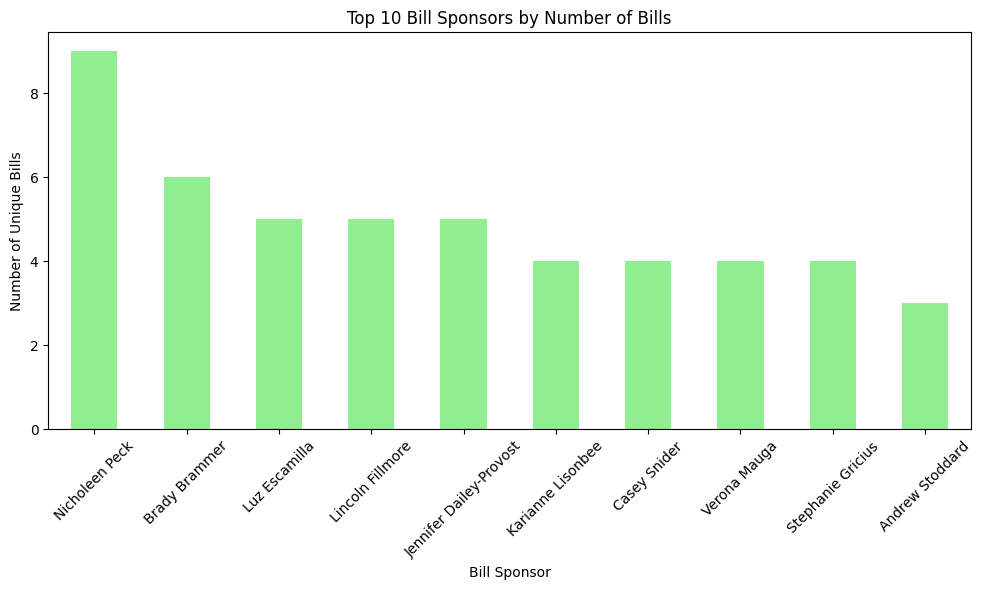

In [ ]:
# Count the number of unique bills per sponsor
sponsor_bill_counts = merged_df.groupby('Bill Sponsor')['Bill Number'].nunique().sort_values(ascending=False).head(10)

# Plot the top 10 bill sponsors by the number of unique bills
plt.figure(figsize=(10,6))
sponsor_bill_counts.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Bill Sponsors by Number of Bills')
plt.xlabel('Bill Sponsor')
plt.ylabel('Number of Unique Bills')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Import reps_bills_combined.json file that ExtractData_CreateJson script creates
reps = pd.read_json('/content/drive/My Drive/ElectionTime/data/reps_bills_combined.json')
reps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Img_ID                         104 non-null    object
 1   Office                         104 non-null    object
 2   Rep_Name                       104 non-null    object
 3   District                       104 non-null    int64 
 4   Party                          104 non-null    object
 5   Email                          104 non-null    object
 6   County(ies)                    104 non-null    object
 7   Webpage                        104 non-null    object
 8   Img_URL                        104 non-null    object
 9   Legislation_By_Representative  104 non-null    object
 10  Bill Sponsor                   104 non-null    object
 11  New_Bills                      104 non-null    object
 12  Passed_Bills                   104 non-null    object
dtypes: in

In [ ]:
reps.loc[90]['New_Bills']

[{'Bill Number': 'SB0269',
  'Link to Bill': 'https://le.utah.gov/~2025/bills/static/SB0269.html',
  'Short Title': 'Telecommunications Amendments',
  'Sponsor': 'Sen. Harper, W.',
  'Date Numbered': 1739318400000,
  'Office': 'State Senate',
  'First Initial': 'W',
  'Middle': None,
  'Last Name': 'Harper',
  'sheet_name': 'new_bills_02142025',
  'Bill Sponsor': 'Harper, W.'},
 {'Bill Number': 'SB0253',
  'Link to Bill': 'https://le.utah.gov/~2025/bills/static/SB0253.html',
  'Short Title': 'Railroad and Transportation Amendments',
  'Sponsor': 'Sen. Harper, W.',
  'Date Numbered': 1739145600000,
  'Office': 'State Senate',
  'First Initial': 'W',
  'Middle': None,
  'Last Name': 'Harper',
  'sheet_name': 'new_bills_02142025',
  'Bill Sponsor': 'Harper, W.'}]

In [ ]:
# I created the reps dataframe with info from the legislative process,
# but there are a few columns that I dont think i'll need now or might be too messy
# - the bill formats are different and idk is it worth pivoting and all that.
# so for now let's drop those columns to keep the data clean and figure out
# what to do with that data later. Like, do we even need it?

reps = reps.drop(columns=["New_Bills", "Passed_Bills"], errors="ignore").reset_index(drop=True)

In [ ]:
reps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Img_ID                         104 non-null    object
 1   Office                         104 non-null    object
 2   Rep_Name                       104 non-null    object
 3   District                       104 non-null    int64 
 4   Party                          104 non-null    object
 5   Email                          104 non-null    object
 6   County(ies)                    104 non-null    object
 7   Webpage                        104 non-null    object
 8   Img_URL                        104 non-null    object
 9   Legislation_By_Representative  104 non-null    object
 10  Bill Sponsor                   104 non-null    object
dtypes: int64(1), object(10)
memory usage: 9.1+ KB


In [ ]:
# Function to generate Sponsor_Key
def create_sponsor_key(rep_name, office):
    last_name = rep_name.split()[-1]  # Last word in Rep_Name
    first_initial = rep_name.split()[0][0]  # First letter of first word
    office_short = "House" if "House" in office else "Senate"  # Simplify Office
    return f"{last_name}{first_initial}_{office_short}"

# Apply function to create Sponsor_Key
reps['Sponsor_Key'] = reps.apply(lambda row: create_sponsor_key(row['Rep_Name'], row['Office']), axis=1)

# Display results
print(reps[['Rep_Name', 'Office', 'Sponsor_Key']].head())


             Rep_Name       Office      Sponsor_Key
0   Thomas W Peterson  State House  PetersonT_House
1  Michael J Petersen  State House  PetersenM_House
2    Jason E Thompson  State House  ThompsonJ_House
3        Tiara Auxier  State House    AuxierT_House
4        Casey Snider  State House    SniderC_House


In [ ]:
# Apply function to create Sponsor_Key
merged_df['Sponsor_Key'] = merged_df.apply(lambda row: create_sponsor_key(row['Bill Sponsor'], row['Office']), axis=1)

# Display results
print(merged_df[['Bill Sponsor', 'Office', 'Sponsor_Key']].head())


            Bill Sponsor       Office            Sponsor_Key
0           Tyler Clancy  State House          ClancyT_House
1           Tyler Clancy  State House          ClancyT_House
2           Tyler Clancy  State House          ClancyT_House
3          Angela Romero  State House          RomeroA_House
4  Kay J. Christofferson  State House  ChristoffersonK_House


In [ ]:
merged_df.loc[merged_df['Bill Number'] == 'HB 209']

,Bill Number,Process Tag,Date,Day of Legislature,Progress,Bill Title,Description,Notecard,Topics,Read,Bill Sponsor,Office,Sponsor_Key
38,HB 209,Floor Vote 1.1,2025-02-03,14,3.0,Homeschool Amendments,Removes the requirement for homeschool parents...,"Trust Us, We're Parents",Education,Negative,Nicholeen Peck,State House,PeckN_House
39,HB 209,Rules 2,2025-02-06,17,6.0,Homeschool Amendments,Removes the requirement for homeschool parents...,"Trust Us, We're Parents",Education,Negative,Nicholeen Peck,State House,PeckN_House
40,HB 209,Committee 2,2025-02-18,29,7.0,Homeschool Amendments,Removes the requirement for homeschool parents...,"Trust Us, We're Parents",Education,Negative,Nicholeen Peck,State House,PeckN_House
41,HB 209,Floor Vote 2.1,2025-02-19,30,8.0,Homeschool Amendments,Removes the requirement for homeschool parents...,"Trust Us, We're Parents",Education,Negative,Nicholeen Peck,State House,PeckN_House
42,HB 209,Floor Vote 2.2,2025-02-20,31,9.0,Homeschool Amendments,Removes the requirement for homeschool parents...,"Trust Us, We're Parents",Education,Negative,Nicholeen Peck,State House,PeckN_House
43,HB 209,Floor Vote 2.3,2025-02-27,38,10.0,Homeschool Amendments,Removes the requirement for homeschool parents...,"Trust Us, We're Parents",Education,Negative,Nicholeen Peck,State House,PeckN_House
44,HB 209,Concurrance,2025-03-03,42,10.5,Homeschool Amendments,Removes the requirement for homeschool parents...,"Trust Us, We're Parents",Education,Negative,Nicholeen Peck,State House,PeckN_House


In [ ]:
# Merge on Sponsor_Key using a left join
all_data = merged_df.merge(reps, on='Sponsor_Key', how='left', suffixes=('_bill', '_rep'))

# Check
print(all_data.info())

# Convert District to int, handling NaNs if any
all_data['District'] = all_data['District'].fillna(0).astype(int)

# Confirm the change
print(all_data.dtypes)

# drop Rep_Name becuase Bill Sponsor_bill is the same info as well as dropping Office_rep becuase Office_bill is the same info
all_data = all_data.drop(columns=["Rep_Name", "Office_rep", "Bill Sponsor_rep"], errors="ignore").reset_index(drop=True)

# Rename the columns
all_data = all_data.rename(columns={'Bill Sponsor_bill': 'Bill_Sponsor', 'Office_bill': 'Office'})

# Replace spaces with _ in column names
all_data.columns = all_data.columns.str.replace(' ', '_')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Bill Number                    429 non-null    object        
 1   Process Tag                    429 non-null    object        
 2   Date                           429 non-null    datetime64[ns]
 3   Day of Legislature             429 non-null    int64         
 4   Progress                       429 non-null    float64       
 5   Bill Title                     429 non-null    object        
 6   Description                    429 non-null    object        
 7   Notecard                       429 non-null    object        
 8   Topics                         429 non-null    object        
 9   Read                           429 non-null    object        
 10  Bill Sponsor_bill              429 non-null    object        
 11  Office_bill        

In [ ]:
# Need a way to fill the progress bar.
all_data['Progress'] = all_data['Progress'].fillna(0).astype(int)

In [ ]:
all_data.loc[all_data['Bill_Number'] == 'HB 209']

,Bill_Number,Process_Tag,Date,Day_of_Legislature,Progress,Bill_Title,Description,Notecard,Topics,Read,...,Office,Sponsor_Key,Img_ID,District,Party,Email,County(ies),Webpage,Img_URL,Legislation_By_Representative
38,HB 209,Floor Vote 1.1,2025-02-03,14,3,Homeschool Amendments,Removes the requirement for homeschool parents...,"Trust Us, We're Parents",Education,Negative,...,State House,PeckN_House,PECKNI,28,R,npeck@le.utah.gov,Tooele,https://house.utleg.gov/rep/PECKNI,https://le.utah.gov/images/legislator/house/PE...,https://le.utah.gov/asp/billsintro/SenResults....
39,HB 209,Rules 2,2025-02-06,17,6,Homeschool Amendments,Removes the requirement for homeschool parents...,"Trust Us, We're Parents",Education,Negative,...,State House,PeckN_House,PECKNI,28,R,npeck@le.utah.gov,Tooele,https://house.utleg.gov/rep/PECKNI,https://le.utah.gov/images/legislator/house/PE...,https://le.utah.gov/asp/billsintro/SenResults....
40,HB 209,Committee 2,2025-02-18,29,7,Homeschool Amendments,Removes the requirement for homeschool parents...,"Trust Us, We're Parents",Education,Negative,...,State House,PeckN_House,PECKNI,28,R,npeck@le.utah.gov,Tooele,https://house.utleg.gov/rep/PECKNI,https://le.utah.gov/images/legislator/house/PE...,https://le.utah.gov/asp/billsintro/SenResults....
41,HB 209,Floor Vote 2.1,2025-02-19,30,8,Homeschool Amendments,Removes the requirement for homeschool parents...,"Trust Us, We're Parents",Education,Negative,...,State House,PeckN_House,PECKNI,28,R,npeck@le.utah.gov,Tooele,https://house.utleg.gov/rep/PECKNI,https://le.utah.gov/images/legislator/house/PE...,https://le.utah.gov/asp/billsintro/SenResults....
42,HB 209,Floor Vote 2.2,2025-02-20,31,9,Homeschool Amendments,Removes the requirement for homeschool parents...,"Trust Us, We're Parents",Education,Negative,...,State House,PeckN_House,PECKNI,28,R,npeck@le.utah.gov,Tooele,https://house.utleg.gov/rep/PECKNI,https://le.utah.gov/images/legislator/house/PE...,https://le.utah.gov/asp/billsintro/SenResults....
43,HB 209,Floor Vote 2.3,2025-02-27,38,10,Homeschool Amendments,Removes the requirement for homeschool parents...,"Trust Us, We're Parents",Education,Negative,...,State House,PeckN_House,PECKNI,28,R,npeck@le.utah.gov,Tooele,https://house.utleg.gov/rep/PECKNI,https://le.utah.gov/images/legislator/house/PE...,https://le.utah.gov/asp/billsintro/SenResults....
44,HB 209,Concurrance,2025-03-03,42,10,Homeschool Amendments,Removes the requirement for homeschool parents...,"Trust Us, We're Parents",Education,Negative,...,State House,PeckN_House,PECKNI,28,R,npeck@le.utah.gov,Tooele,https://house.utleg.gov/rep/PECKNI,https://le.utah.gov/images/legislator/house/PE...,https://le.utah.gov/asp/billsintro/SenResults....


In [ ]:
# save all_data to a json file called bad_bills_data.json
filename = "bad_bills_combined.json"
all_data.to_json(filepath + filename, orient='records')


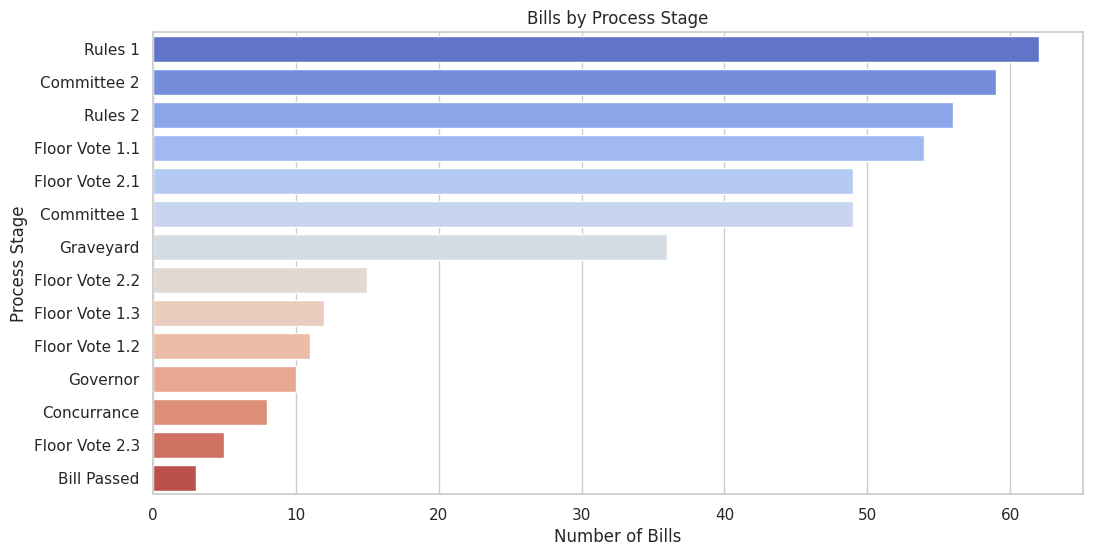

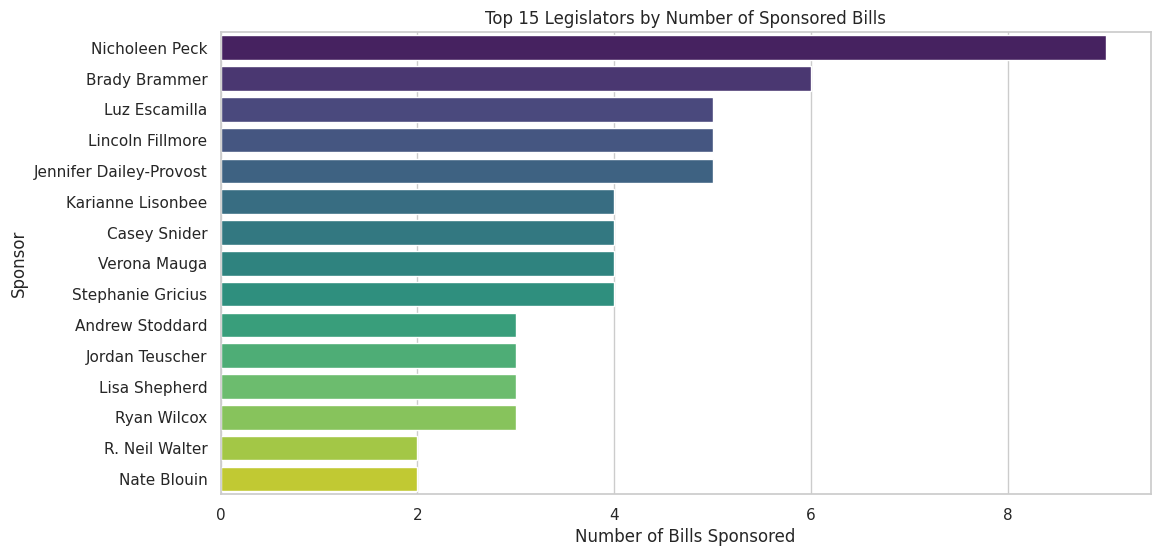

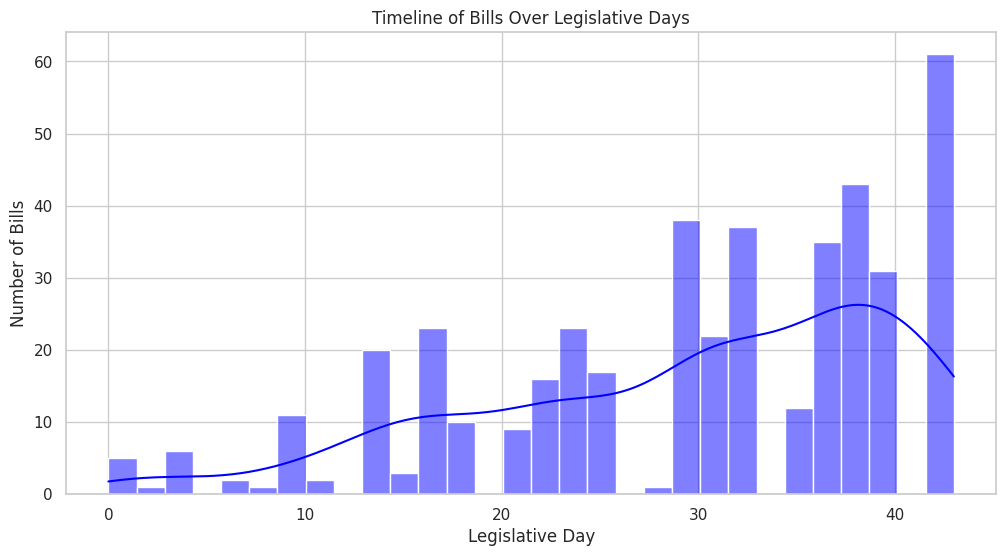

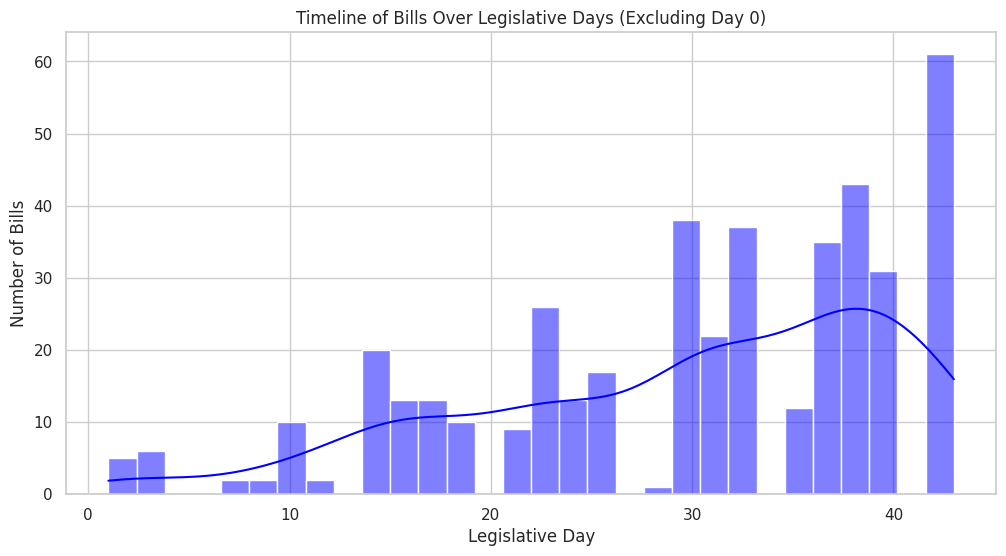

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a style
sns.set_theme(style="whitegrid")

# 1️⃣ Count of Bills in Each Process Stage
plt.figure(figsize=(12, 6))
sns.countplot(y=all_data['Process_Tag'], order=all_data['Process_Tag'].value_counts().index, palette="coolwarm")
plt.xlabel("Number of Bills")
plt.ylabel("Process Stage")
plt.title("Bills by Process Stage")
plt.savefig(filepath + "bills_by_process_stage.png", dpi=300, bbox_inches="tight")  # Save chart
plt.show()

# 2️⃣ Number of Bills by Sponsor (Top 15)
plt.figure(figsize=(12, 6))
# top_sponsors = all_data['Bill Sponsor'].value_counts().head(15)
top_sponsors = all_data.groupby('Bill_Sponsor')['Bill_Number'].nunique().sort_values(ascending=False).head(15)
sns.barplot(x=top_sponsors.values, y=top_sponsors.index, palette="viridis")
plt.xlabel("Number of Bills Sponsored")
plt.ylabel("Sponsor")
plt.title("Top 15 Legislators by Number of Sponsored Bills")
plt.savefig(filepath + "top_legislators_by_bills.png", dpi=300, bbox_inches="tight")  # Save chart
plt.show()

# 3️⃣ Timeline of Bills (Bills over Legislative Days)
plt.figure(figsize=(12, 6))
sns.histplot(all_data['Day_of_Legislature'], bins=30, kde=True, color="blue")
plt.xlabel("Legislative Day")
plt.ylabel("Number of Bills")
plt.title("Timeline of Bills Over Legislative Days")
plt.show()

# 3️⃣ Timeline of Bills (Bills over Legislative Days) - Exclude Day of Legislature == 0
plt.figure(figsize=(12, 6))
filtered_data = all_data[all_data['Day_of_Legislature'] > 0]  # Exclude 0 values
sns.histplot(filtered_data['Day_of_Legislature'], bins=30, kde=True, color="blue")
plt.xlabel("Legislative Day")
plt.ylabel("Number of Bills")
plt.title("Timeline of Bills Over Legislative Days (Excluding Day 0)")
plt.savefig(filepath + "timeline_of_bills.png", dpi=300, bbox_inches="tight")  # Save chart
plt.show()

In [ ]:
# Combine bb and reps dataframes to create json file